In [1]:
pip install mediapipe 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 22.8 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import cv2
import mediapipe as mp
import numpy as np
import pandas as ps
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import color

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsRegressor

from matplotlib.colors import ListedColormap

In [3]:
def plot(data, nb, x, y, i):
    plt.figure(figsize=(16,10))
    sns.scatterplot(
    x=x, y = y,
    hue = i,
    palette = sns.color_palette("hls", nb),
    data = data,
    legend = "full",
    alpha=0.3
)

In [4]:
def getContours(img, imgContour):
    # find all the contours from the B&W image
    contours, hierarchy = cv2.findContours(img, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # needed to filter only our contours of interest
    finalContours = []

    # for each contour found
    for cnt in contours:
        #cv2.drawContours(imgContour, cnt, -1, (255, 255, 0), 1)
        # find its area in pixel
        area = cv2.contourArea(cnt)
        #print("Detected Contour with Area: ", area)

        perimeter = cv2.arcLength(cnt, True)

        # smaller epsilon -> more vertices detected [= more precision]
        epsilon = 0.002 * perimeter
        # check how many vertices
        approx = cv2.approxPolyDP(cnt, epsilon, True)
        # print(len(approx))

        finalContours.append([len(approx), area, approx, cnt])

    #print("---\nFinal number of External Contours: ", len(finalContours))
    # sorting in descending order depending on the area
    finalContours = sorted(finalContours, key=lambda x: x[1], reverse=True)

    # drawing contours for the final objects
    #for con in finalContours:
       # cv2.drawContours(imgContour, con[3], -1, (0, 0, 255), 3)

    return imgContour, finalContours

In [5]:
def getGeometricFeatures(path):
    mpFaceMesh = mp.solutions.face_mesh
    faceMesh = mpFaceMesh.FaceMesh(max_num_faces=1)

    #print(path)
    img = cv2.imread(path)
    b,g,r = cv2.split(img)           # get b, g, r
    rgb_img1 = cv2.merge([r,g,b])
    
    imgRGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = faceMesh.process(imgRGB)

    width = 0
    heigh = 0
    
    p_up_inner = 0
    p_down_inner = 0
    p_right_inner = 0
    p_left_inner = 0
    top_mouth = 0
    p_up_outer = 0
    p_down_outer = 0
    p_left_outer = 0

    if results.multi_face_landmarks:
        for faceLns in results.multi_face_landmarks:
            for id_, lm in enumerate(faceLns.landmark):
                ih, iw, ic = img.shape
                x, y , z = int(lm.x*iw), int(lm.y*ih), int(lm.z*ic)

                if id_ == 13: 
                    p_up_inner = [x, y]
                    
                elif id_ == 17: 
                    p_down_outer = [x, y]
                
                elif id_ == 61: 
                    p_left_outer = [x, y]
                    
                elif id_ == 291: 
                    p_right_outer = [x, y]
                    
                elif id_ == 0: 
                    p_up_outer = [x, y]
                    
                elif id_ == 14: 
                    p_down_inner = [x, y] 
                    
                elif id_ == 78: 
                    p_left_inner = [x, y]
                    
                elif id_ == 308: 
                    p_right_inner = [x, y]
                    
                elif id_ == 164: top_mouth = [x, y]
                    
    if top_mouth != 0:
        width = (p_right_inner[0] - p_left_inner[0])
        heigh = (p_down_inner[1] - p_up_inner[1]) 
        mouth = rgb_img1[p_up_outer[1]:p_down_outer[1], p_left_outer[0]:p_right_outer[0]]
        
    return width, heigh, mouth

In [6]:
def getDarkArea(mouthImage):
    # transform the image into gray scale
    grayImage = cv2.cvtColor(mouthImage, cv2.COLOR_BGR2GRAY)
    slicePixelArea = 0
    
    # transform the gray scale image into black and white
    (thresh, blackAndWhiteImage) = cv2.threshold(grayImage, 20, 255, cv2.THRESH_BINARY)

    # for the edges of the dark area
    imgCanny = cv2.Canny(blackAndWhiteImage, 255, 195)
    kernel = np.ones((2, 2))
    imgDil = cv2.dilate(imgCanny, kernel, iterations=3)
    imgThre = cv2.erode(imgDil, kernel, iterations=3)
    
    imgFinalContours, finalContours = getContours(imgThre, mouthImage)
    
    
    if len(finalContours) != 0:
        slicePixelArea = finalContours[0][1]
        #print("Entire Slice Area in pixel", slicePixelArea)
    return slicePixelArea

In [7]:
def getFeatures(path, i, personne):
    features = []#ps.DataFrame()
    #features.append(personne)
    #print(path)
    for imgName in os.listdir(path):
        
        image_path = path + "/" + imgName
        
        width, heigh, mouth = getGeometricFeatures(image_path)
        
        features.append(width)
        features.append(heigh)
        features.append(getDarkArea(mouth))
#         dct = getDCTfeatures(image_path)
#         features.append(dct)
        #
    features.append(i)
    #features = np.resize(features, (1, len(features)))
    #print(features)
    #print("features shape : ", np.array(features).shape)
    return features

In [8]:
def syllabeFeatures(path, i):
    syllabeFeatures = []
    #syllabeFeatures = np.array(syllabeFeatures)
    for sd in os.listdir(path):
        print(sd)
        sub_sub_dir = path + "/" + sd
        #print(i)

        #syllabeFeatures = np.append(syllabeFeatures, getFeatures(sub_sub_dir, i))
        syllabeFeatures.append(getFeatures(sub_sub_dir, i, sd))
    #yllabeFeatures = np.array(syllabeFeatures)
    print("data shape : ", np.array(syllabeFeatures).shape)
        #if sd == "M2U02788" : break

    return syllabeFeatures

In [9]:
train_path = "../input/voyelleface/voyelles/train/"
i = 0
geoFeatures = []
for d in os.listdir(train_path):
    path = train_path +d
    print(path)
    syl_features = syllabeFeatures(path, d)
    geoFeatures.append(syl_features)
    i += 1

../input/voyelleface/voyelles/train/u!--
M2U02804


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


M2U02802
M2U02799
M2U02805_
M2U02796
M2U02801
M2U02809_
M2U02786
M2U02808_
M2U02789
M2U02792
M2U02806_
M2U02807_
M2U02797
M2U02800
M2U02787
M2U02798
M2U02788
M2U02791


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if sys.path[0] == "":


data shape :  (19,)
../input/voyelleface/voyelles/train/i!--
M2U02804
M2U02802
M2U02799
M2U02805_
M2U02796
M2U02801
M2U02809_
M2U02786
M2U02792
M2U02807_
M2U02797
M2U02800
M2U02787
M2U02798
M2U02791
data shape :  (15,)
../input/voyelleface/voyelles/train/a!--
M2U02804
M2U02802
M2U02799
M2U02805_
M2U02796
M2U02809_
M2U02786
M2U02808_
M2U02789
M2U02792
M2U02806_
M2U02807_
M2U02797
M2U02800
M2U02787
M2U02798
M2U02788
M2U02791
data shape :  (18,)


In [10]:
test_path = "../input/voyelleface/voyelles/test/"
i = 0
test_geoFeatures = []
for d in os.listdir(test_path):
    path = test_path +d
    print(path)
    syl_features = syllabeFeatures(path, d)
    test_geoFeatures.append(syl_features)
    i += 1

../input/voyelleface/voyelles/test/u!--
M2U02794
M2U02790
M2U02795
M2U02803


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if sys.path[0] == "":


data shape :  (4,)
../input/voyelleface/voyelles/test/i!--
M2U02794
M2U02790
M2U02795
M2U02803
data shape :  (4,)
../input/voyelleface/voyelles/test/a!--
M2U02794
M2U02790
M2U02795
M2U02803
data shape :  (4,)


In [11]:
train_df_final = ps.DataFrame()
columnsNames = ['width', 'height','darkArea']
for feature in geoFeatures:
    for fea in feature:
        columns_ = []
        nb = (int((np.array(fea).shape[0]-1)/3))
        #columns_.append('personne')
        temp = [name + str(i) for i in range(nb) for name in columnsNames]
        columns_.extend(temp)
        columns_.append('i')
        
        df = ps.DataFrame(data = [fea], columns = columns_)
        train_df_final = train_df_final.append(df, 1)

In [12]:
test_df_final = ps.DataFrame()
columnsNames = ['width', 'height','darkArea']
for feature in test_geoFeatures:
    for fea in feature:
        columns_ = []
        nb = (int((np.array(fea).shape[0]-1)/3))
        #columns_.append('personne')
        temp = [name + str(i) for i in range(nb) for name in columnsNames]
        columns_.extend(temp)
        columns_.append('i')
        
        df = ps.DataFrame(data = [fea], columns = columns_)
        test_df_final = test_df_final.append(df, 1)

In [15]:
train_df_final['i']

0     u!--
1     u!--
2     u!--
3     u!--
4     u!--
5     u!--
6     u!--
7     u!--
8     u!--
9     u!--
10    u!--
11    u!--
12    u!--
13    u!--
14    u!--
15    u!--
16    u!--
17    u!--
18    u!--
19    i!--
20    i!--
21    i!--
22    i!--
23    i!--
24    i!--
25    i!--
26    i!--
27    i!--
28    i!--
29    i!--
30    i!--
31    i!--
32    i!--
33    i!--
34    a!--
35    a!--
36    a!--
37    a!--
38    a!--
39    a!--
40    a!--
41    a!--
42    a!--
43    a!--
44    a!--
45    a!--
46    a!--
47    a!--
48    a!--
49    a!--
50    a!--
51    a!--
Name: i, dtype: object

In [14]:
test_df_final

,width0,height0,darkArea0,width1,height1,darkArea1,width2,height2,darkArea2,width3,...,darkArea33,width34,height34,darkArea34,width35,height35,darkArea35,width36,height36,darkArea36
0,33,6,0.0,33,6,4.0,34,6,0.0,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,37,4,0.0,36,4,0.0,36,5,0.0,37,...,0.0,36.0,4.0,0.0,36.0,4.0,0.0,36.0,4.0,0.0
2,28,3,4.0,28,3,0.0,28,3,0.5,29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,33,11,11.5,34,3,0.0,32,3,3.0,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,43,9,0.0,41,6,0.0,44,6,0.0,44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,44,17,8.5,44,17,8.5,44,17,8.5,44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,45,17,12.0,45,17,9.0,43,17,11.5,44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,34,11,0.0,35,11,4.0,34,11,4.0,34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,37,6,57.5,38,12,95.5,38,15,57.0,36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,41,18,103.5,39,15,96.0,40,19,118.5,38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
df_final = test_df_final

In [18]:
df_mean = ps.DataFrame()

temp = df_final[df_final.columns[ps.Series(df_final.columns).str.startswith('width')]].mean(axis=1)
df_mean['widthMean'] = temp

temp = df_final[df_final.columns[ps.Series(df_final.columns).str.startswith('height')]].mean(axis=1)
df_mean['heightMean'] = temp

temp = df_final[df_final.columns[ps.Series(df_final.columns).str.startswith('darkArea')]].mean(axis=1)
df_mean['darAreaMean'] = temp

#df_mean['personne'] = df_final['personne']

df_mean['width/height'] = df_mean["widthMean"].div(df_mean["heightMean"].values)

df_mean['height/width'] = df_mean["heightMean"].div(df_mean["widthMean"].values)

df_mean['i'] = df_final['i']

df_mean

,widthMean,heightMean,darAreaMean,width/height,height/width,i
0,33.882353,6.941176,1.470588,4.881356,0.204861,u!--
1,36.756757,4.270270,0.986486,8.607595,0.116176,u!--
2,28.461538,3.230769,5.000000,8.809524,0.113514,u!--
3,33.111111,6.555556,5.166667,5.050847,0.197987,u!--
4,42.882353,6.235294,0.911765,6.877358,0.145405,i!--
5,44.000000,17.000000,8.500000,2.588235,0.386364,i!--
6,43.785714,16.785714,9.785714,2.608511,0.383361,i!--
7,34.555556,11.222222,1.555556,3.079208,0.324759,i!--
8,37.176471,13.647059,64.058824,2.724138,0.367089,a!--
9,39.588235,16.000000,95.382353,2.474265,0.404160,a!--


In [19]:
test_df_mean = df_mean

In [21]:
train_df_mean

,widthMean,heightMean,darAreaMean,width/height,height/width,i
0,27.866667,5.133333,30.000000,5.428571,0.184211,u!--
1,28.363636,4.181818,10.500000,6.782609,0.147436,u!--
2,28.083333,5.416667,16.541667,5.184615,0.192878,u!--
3,31.250000,3.250000,1.312500,9.615385,0.104000,u!--
4,32.777778,5.888889,1.444444,5.566038,0.179661,u!--
5,29.785714,4.857143,15.428571,6.132353,0.163070,u!--
6,31.818182,3.454545,1.863636,9.210526,0.108571,u!--
7,40.666667,7.000000,23.666667,5.809524,0.172131,u!--
8,27.000000,5.000000,12.750000,5.400000,0.185185,u!--
9,42.421053,6.000000,16.052632,7.070175,0.141439,u!--


In [28]:
train_df_mean

,widthMean,heightMean,darAreaMean,width/height,height/width,i
0,27.866667,5.133333,30.000000,5.428571,0.184211,u!--
1,28.363636,4.181818,10.500000,6.782609,0.147436,u!--
2,28.083333,5.416667,16.541667,5.184615,0.192878,u!--
3,31.250000,3.250000,1.312500,9.615385,0.104000,u!--
4,32.777778,5.888889,1.444444,5.566038,0.179661,u!--
5,29.785714,4.857143,15.428571,6.132353,0.163070,u!--
6,31.818182,3.454545,1.863636,9.210526,0.108571,u!--
7,40.666667,7.000000,23.666667,5.809524,0.172131,u!--
8,27.000000,5.000000,12.750000,5.400000,0.185185,u!--
9,42.421053,6.000000,16.052632,7.070175,0.141439,u!--


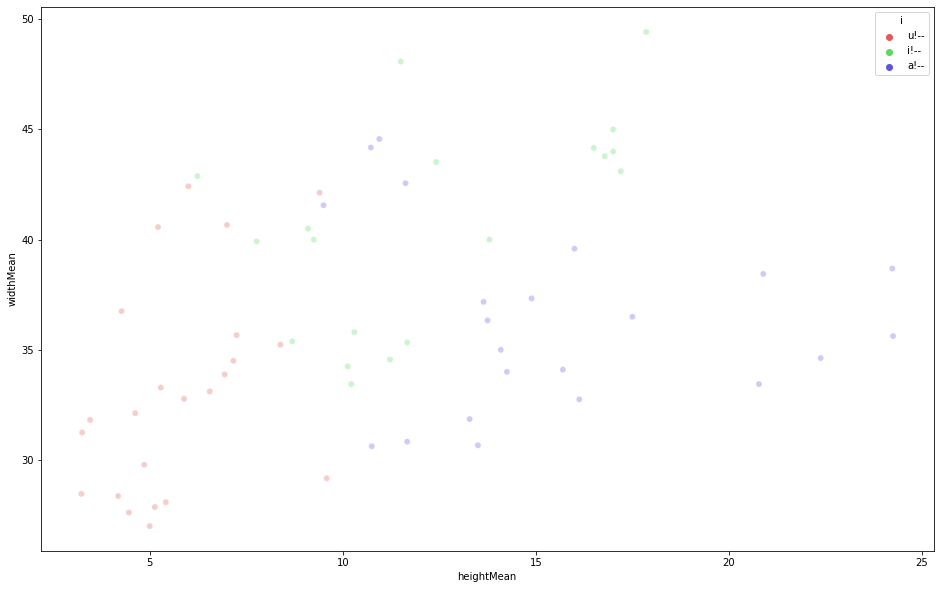

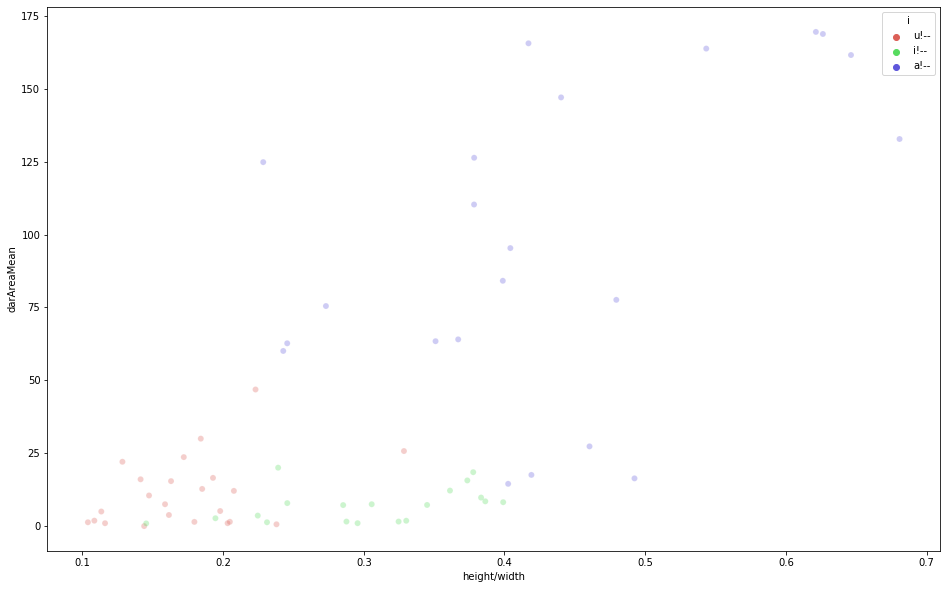

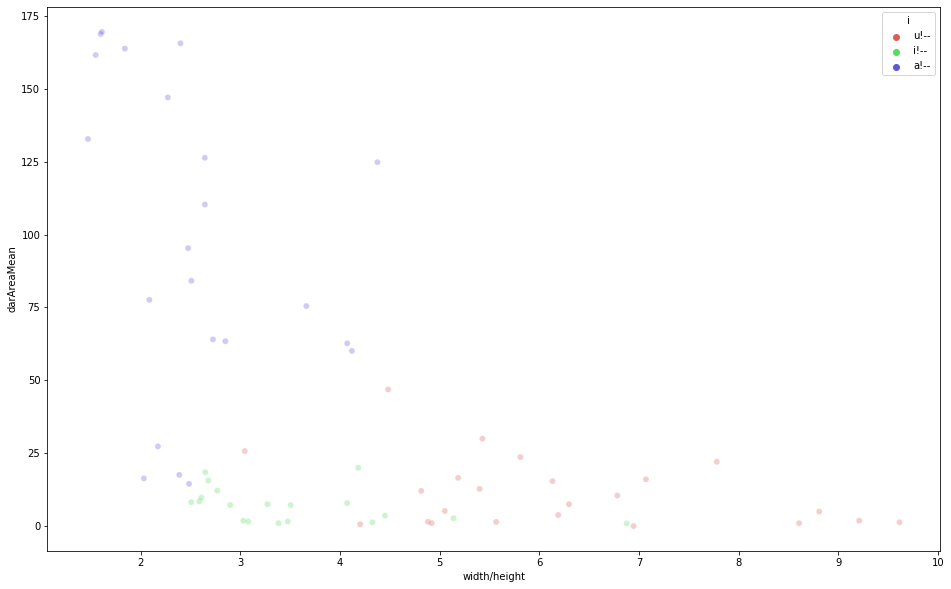

In [13]:
plot(df_mean, 3, 'heightMean', 'widthMean', 'i') 
plot(df_mean, 3, 'height/width', 'darAreaMean', 'i') #a!-- i!-- u!--
plot(df_mean, 3, 'width/height', 'darAreaMean', 'i') #a!-- i!-- u!--

In [22]:
data = train_df_mean
print(data)

    widthMean  heightMean  darAreaMean  width/height  height/width     i
0   27.866667    5.133333    30.000000      5.428571      0.184211  u!--
1   28.363636    4.181818    10.500000      6.782609      0.147436  u!--
2   28.083333    5.416667    16.541667      5.184615      0.192878  u!--
3   31.250000    3.250000     1.312500      9.615385      0.104000  u!--
4   32.777778    5.888889     1.444444      5.566038      0.179661  u!--
5   29.785714    4.857143    15.428571      6.132353      0.163070  u!--
6   31.818182    3.454545     1.863636      9.210526      0.108571  u!--
7   40.666667    7.000000    23.666667      5.809524      0.172131  u!--
8   27.000000    5.000000    12.750000      5.400000      0.185185  u!--
9   42.421053    6.000000    16.052632      7.070175      0.141439  u!--
10  35.666667    7.250000     1.000000      4.919540      0.203271  u!--
11  27.615385    4.461538     3.807692      6.189655      0.161560  u!--
12  32.125000    4.625000     0.000000      6.94594

In [15]:
training_set, test_set = train_test_split(data, test_size = 0.2, random_state = 1)
#print(training_set, test_set)

In [16]:
training_set = train_df_final
test_set = test_df_final

In [18]:
Y_train = training_set['i']
X_train = training_set.drop('i', axis=1)
Y_test = test_set['i']
X_test = test_set.drop('i', axis=1)

print(X_train, Y_train, X_test, Y_test)

    width0  height0  darkArea0  width1  height1  darkArea1  width2  height2  \
0       27        4       28.0      28        5       37.5      28        4   
1       28        5        8.0      28        4       12.0      28        5   
2       27        5       14.0      29        6       38.0      29        5   
3       32        3        4.0      31        3        3.0      31        3   
4       33        5        0.0      33        5        0.0      33        6   
5       30        4       13.5      30        5       15.5      30        4   
6       32        3        0.0      31        4        5.0      32        3   
7       40        6       21.0      42        8       27.0      41        6   
8       27        4       22.0      29        5        5.0      27        4   
9       43        6       15.0      43        5       15.0      44        6   
10      35        6        0.0      36        6        0.0      37        9   
11      28        4        4.0      27        5     

In [24]:
X_test = X_test.fillna(value=0)
X_test

,width0,height0,darkArea0,width1,height1,darkArea1,width2,height2,darkArea2,width3,...,darkArea33,width34,height34,darkArea34,width35,height35,darkArea35,width36,height36,darkArea36
0,33,6,0.0,33,6,4.0,34,6,0.0,33,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,37,4,0.0,36,4,0.0,36,5,0.0,37,...,0.0,36.0,4.0,0.0,36.0,4.0,0.0,36.0,4.0,0.0
2,28,3,4.0,28,3,0.0,28,3,0.5,29,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,33,11,11.5,34,3,0.0,32,3,3.0,33,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,43,9,0.0,41,6,0.0,44,6,0.0,44,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,44,17,8.5,44,17,8.5,44,17,8.5,44,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,45,17,12.0,45,17,9.0,43,17,11.5,44,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,34,11,0.0,35,11,4.0,34,11,4.0,34,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,37,6,57.5,38,12,95.5,38,15,57.0,36,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,41,18,103.5,39,15,96.0,40,19,118.5,38,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
classifier = SVC(kernel='poly', random_state = 1)
train = classifier.fit(X_train,Y_train)
train

SVC(kernel='poly', random_state=1)

In [27]:
train.fit_status_

0

In [29]:
Y_pred = classifier.predict(X_test)

In [31]:
test_set["Predictions"] = Y_pred
test_set

,width0,height0,darkArea0,width1,height1,darkArea1,width2,height2,darkArea2,width3,...,width34,height34,darkArea34,width35,height35,darkArea35,width36,height36,darkArea36,Predictions
0,33,6,0.0,33,6,4.0,34,6,0.0,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,u!--
1,37,4,0.0,36,4,0.0,36,5,0.0,37,...,36.0,4.0,0.0,36.0,4.0,0.0,36.0,4.0,0.0,u!--
2,28,3,4.0,28,3,0.0,28,3,0.5,29,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,u!--
3,33,11,11.5,34,3,0.0,32,3,3.0,33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,u!--
4,43,9,0.0,41,6,0.0,44,6,0.0,44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,u!--
5,44,17,8.5,44,17,8.5,44,17,8.5,44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,u!--
6,45,17,12.0,45,17,9.0,43,17,11.5,44,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,u!--
7,34,11,0.0,35,11,4.0,34,11,4.0,34,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,u!--
8,37,6,57.5,38,12,95.5,38,15,57.0,36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,a!--
9,41,18,103.5,39,15,96.0,40,19,118.5,38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,a!--


In [32]:
cm = confusion_matrix(Y_test,Y_pred)
accuracy = float(cm.diagonal().sum())/len(Y_test)
print("\nAccuracy Of SVM For The Given Dataset : ", accuracy)


Accuracy Of SVM For The Given Dataset :  0.75


In [33]:
print(confusion_matrix(Y_test, Y_pred))
print(classification_report(Y_test, Y_pred))

[[3 0 1]
 [0 2 2]
 [0 0 4]]
              precision    recall  f1-score   support

        a!--       1.00      0.75      0.86         4
        i!--       1.00      0.50      0.67         4
        u!--       0.57      1.00      0.73         4

    accuracy                           0.75        12
   macro avg       0.86      0.75      0.75        12
weighted avg       0.86      0.75      0.75        12



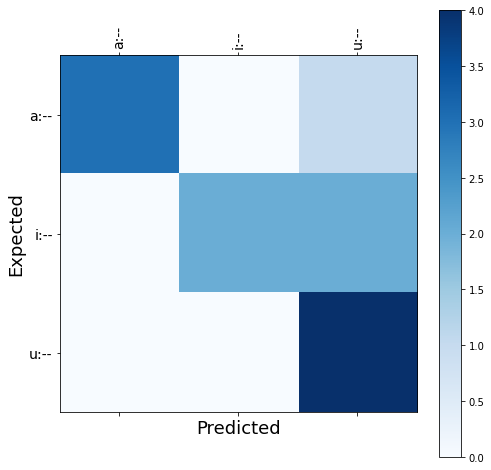

In [34]:
conf_mat = confusion_matrix(y_true=Y_test, y_pred=Y_pred)

fig = plt.figure(figsize=(8,8))
plt.matshow(conf_mat, cmap=plt.cm.Blues, fignum=fig.number)
plt.colorbar()
plt.xticks(np.arange(3), ["a:--", "i:--", "u:--"], rotation=90, fontsize=14)
plt.yticks(np.arange(3), ["a:--", "i:--", "u:--"], fontsize=14)
plt.xlabel('Predicted', fontsize=18)
plt.ylabel('Expected', fontsize=18)
plt.show()

**KNN**

In [83]:
ii = []
for i in data['i']:
    if i == 'a!--':ii.append(0)
    elif i == 'i!--':ii.append(1)
    elif i == 'u!--':ii.append(2)

data['y'] = ii

In [85]:
knn_X_train, knn_X_test, knn_y_train, knn_y_test = train_test_split(data.iloc[:,0:5].values, data.iloc[:,6].values,
                                                                    test_size=0.25, random_state=42)

In [86]:
knn_y_train

array([2, 2, 0, 2, 2, 1, 2, 0, 2, 0, 1, 0, 1, 1, 0, 0, 2, 1, 1, 1, 0, 2,
       1, 0, 0, 1, 1, 0, 0, 2, 2, 2, 0, 1, 1, 1, 0, 2, 2, 2, 0, 2, 2, 0,
       2, 1, 0, 1])

In [87]:
regressor = KNeighborsRegressor(n_neighbors=5)
regressor.fit(knn_X_train, knn_y_train)

KNeighborsRegressor()

In [88]:
y_pred_knn = regressor.predict(knn_X_test)

In [89]:
y_pred_knn

array([0. , 0. , 2. , 0. , 2. , 1. , 1.8, 2. , 1. , 0.8, 0. , 2. , 1.4,
       2. , 1. , 0. ])

In [91]:
mae = mean_absolute_error(knn_y_test, y_pred_knn)
mse = mean_squared_error(knn_y_test, y_pred_knn)
rmse = mean_squared_error(knn_y_test, y_pred_knn, squared=False)

In [92]:
print(f'mae: {mae}')
print(f'mse: {mse}')
print(f'rmse: {rmse}')

mae: 0.0875
mse: 0.052500000000000005
rmse: 0.22912878474779202
